In [2]:
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import OrderedDict
from plotting import line_plot_predictions, plot_cross_val_score
from baseline_models import Baseline_previous, Baseline_average, baseline_forecasts
from sarima_models import Sarima_predictions
from data_wrangling import Results_data, Data_preparation
plt.style.use('fivethirtyeight')

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [153]:
project_name = 'project_e871'
freq = 'D'
season = 7
path = '../../capstone_data/Azimuth/clean/{}'.format(project_name)

In [106]:
dp = Data_preparation(path,freq)
df = dp.get_data()
y = dp.create_variable(agg='sum',feature='power_all')
path_res = '../results/results_daily/output_'+project_name+'_daily'
res = Results_data(path_res).get_data()
results = res.df
results_train =results[results['test']==0]
results_test =results[results['test']==1]

In [107]:
results_train

,project,model,test,baseline_previous,baseline_averages,sarimax,sarima_x_aic,sarimax_params,order,seasonal_order,beta_var
0,project_6d8c,sarima,0,1.377728e+06,1.567242e+06,1.121532e+06,1397.836036,"{'k_ma': 2, 'k_exog': 0, 'measurement_error': ...","(2, 1, 2)","(1, 0, 0, 7)",0
2,project_6d8c,sarimaX,0,1.377728e+06,1.567242e+06,1.043841e+06,1360.536872,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(3, 1, 1)","(1, 0, 0, 7)",0
0,project_6d8c,sarima,0,1.377728e+06,1.567242e+06,1.121532e+06,1397.836036,"{'k_ma': 2, 'k_exog': 0, 'measurement_error': ...","(2, 1, 2)","(1, 0, 0, 7)",1
2,project_6d8c,sarimaX,0,1.377728e+06,1.567242e+06,1.089483e+06,1485.092170,"{'k_ma': 1, 'k_exog': 3, 'measurement_error': ...","(3, 1, 1)","(0, 0, 0, 7)",1


In [108]:
params_s,params_sX,params_sX_v = res.get_params()
print params_s
print params_sX
print params_sX_v

((2, 1, 2), (1, 0, 0, 7))
((3, 1, 1), (1, 0, 0, 7))
((3, 1, 1), (0, 0, 0, 7))


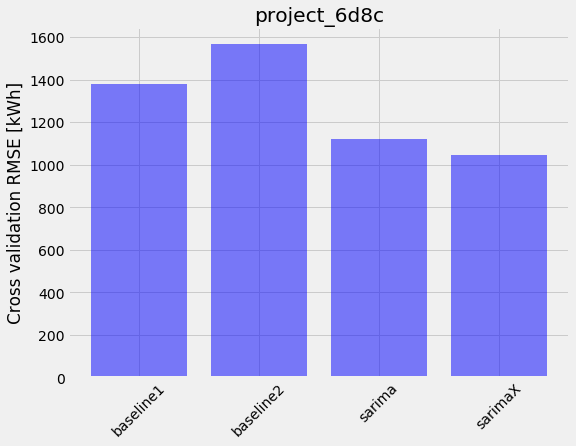

In [109]:
plot_cross_val_score(results_train)

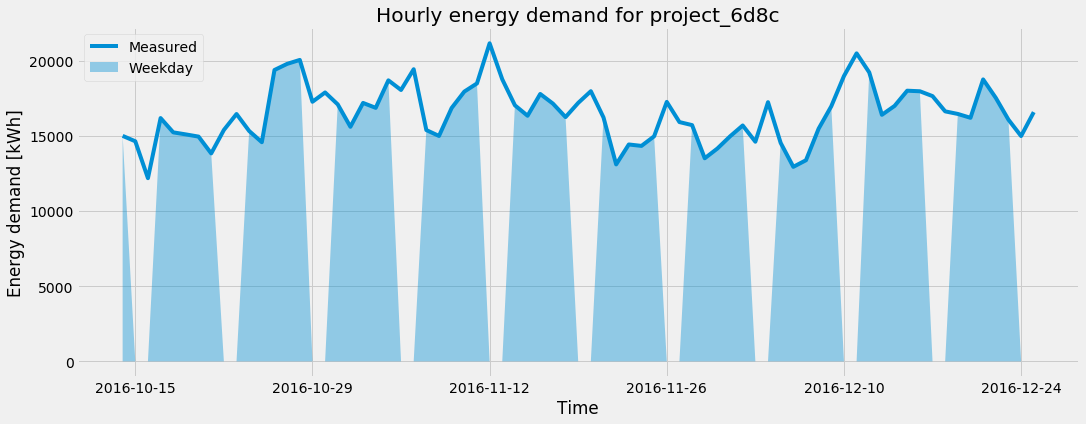

In [110]:
plt.figure(figsize=(16,6))
y_plot = y.iloc[:,0]/1000.
plt.plot(y.index, y_plot,label='Measured')
plt.fill_between(y.index, y.iloc[:,-1]*y_plot, alpha=0.4, label='Weekday')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Energy demand [kWh]')
title = 'Hourly energy demand for {}'.format(project_name)
plt.title(title)
plt.show()

## T-dependance

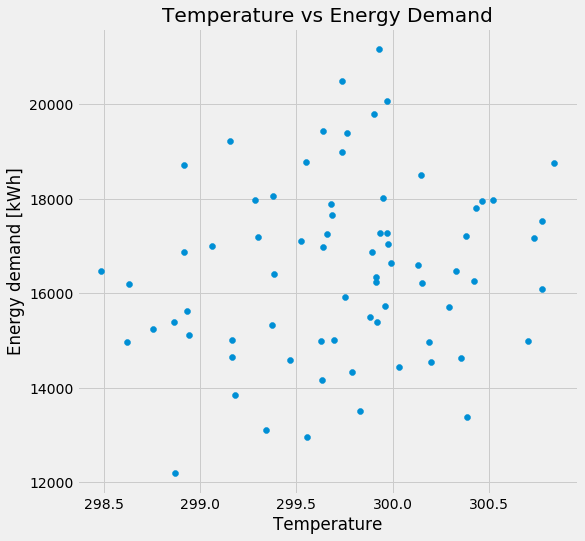

In [111]:
plt.figure(figsize=(8,8))
y_plot = y.iloc[:,0]/1000
plt.scatter(y.iloc[:,1], y_plot)
plt.xlabel('Temperature')
plt.ylabel('Energy demand [kWh]')
title = 'Temperature vs Energy Demand'.format(project_name)
plt.title(title)
plt.show()

In [112]:
y_train = y[:-2*season]
y_test = y[-2*season:]

In [113]:
len(y)

73

In [114]:
endog = y_train.ix[:,0]
exog = sm.add_constant(y_train.ix[:,1:])

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


## Training

In [143]:
predictions = []
window = 5*season

In [116]:
prediction_b1, prediction_b2 = baseline_forecasts(y_train,window,'D')


baseline - previous...
Baseline-previous test RMSE 1558269.26617
baseline - averages....
Baseline-averages test RMSE 1763562.33911


In [117]:
len(prediction_b2)

28

In [118]:
predictions.append(['baseline_previous',prediction_b1])
predictions.append(['baseline_average',prediction_b2])

In [144]:
sp = Sarima_predictions(params_s, 0)
results_s = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
sp = Sarima_predictions(params_sX,1)
results_sX = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)
# sp = Sarima_predictions(params_sX_v,2)
# results_sX_v = sp.rolling_predictions_sarima(y_train,len(y_train)-window, window)

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [145]:
prediction_s = results_s[0]
prediction_sX = results_sX[0]
# prediction_sX_v = results_sX_v[0]

In [146]:
predictions.append(['sarima',prediction_s])
predictions.append(['sarimaX',prediction_sX])
# predictions.append(['sarimaX_v',prediction_sX_v])

In [147]:
[predictions]

[[['sarima', array([ 18893500.01135221,  17215623.96890267,  16347247.07912081,
           16158246.27332047,  17968791.0349175 ,  17630985.85728802,
           20458962.21975883,  17556549.41990989,  17165452.13384692,
           17438448.59500977,  17859948.08464942,  17530182.4691283 ,
           16914602.20266666,  17080899.37261964,  17408778.95210207,
           16631309.09497079,  14444875.46036197,  15176889.7261709 ,
           14816240.99263428,  15596733.69370821,  16886574.68213776,
           15699788.76963616,  15174598.80734256,  14706992.84514646,
           14763596.03784367,  15336389.45690486,  16253587.19697549,
           14928784.36108991,  16584553.10947076,  14845582.32679277,
           13435329.51621325,  14195265.55239202,  15354366.96363635,
           15967044.47470224,  17905099.7047151 ])],
  ['sarimaX',
   array([ 19226244.38742203,  18728421.26971464,  15025007.2068181 ,
           17527852.42761007,  17850498.95315909,  17574365.22691922,
           19

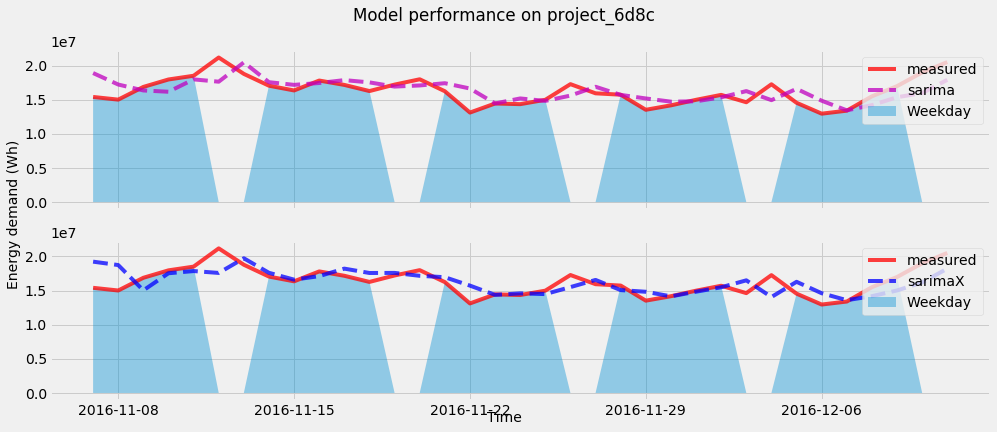

In [152]:
line_plot_predictions(project_name, predictions,y_train.iloc[-window:])

In [123]:
sp = Sarima_predictions(params_sX, 1)
model = sp.fit(y_train)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         power_all   No. Observations:                   59
Model:             SARIMAX(3, 1, 1)x(1, 0, 0, 7)   Log Likelihood                -750.965
Date:                           Tue, 05 Sep 2017   AIC                           1519.931
Time:                                   10:28:41   BIC                           1538.628
Sample:                               10-14-2016   HQIC                          1527.229
                                    - 12-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0     94.059          0      1.000    -184.353     184.353
T-1          4.38e+05   7.37e+05      0.594      0.552   -1.01e+06    1.88e+06
weekday    -7.891e+05   6.58e+05     -1.199      0.230   -2.08e+06    5.01e+05
ar.L1         -0.2137      0.707     -0.302      0.762      -1.599       1.171
ar.L2         -0.1432      0.207     -0.691      0.490      -0.549       0.263
ar.L3         -0.2468      0.202     -1.220      0.223      -0.643       0.150
ma.L1         -0.0448      0.725     -0.062      0.951      -1.466       1.376
ar.S.L7        0.2696      0.234      1.154      0.248      -0.188       0.727
sigma2      2.257e+12      0.360   6.27e+12      0.000    2.26e+12    2.26e+12
===================================================================================
Ljung-Box (Q):                       44.09   Jarque-Bera (JB):                 2.84
Prob(Q):                              0.30   Prob(JB):                         0.24
Heteroskedasticity (H):               0.78   Skew:                             0.49
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+28. Standard errors may be unstable.
"""

## Forecasts

In [124]:
forecasts = []

In [125]:
forecast_b1, forecast_b2 = baseline_forecasts(y,window,'D')


baseline - previous...
Baseline-previous test RMSE 1508270.95267
baseline - averages....
Baseline-averages test RMSE 1793450.77081


In [126]:
forecasts.append(['baseline_previous',forecast_b1])
forecasts.append(['baseline_average',forecast_b2])

In [127]:
sp = Sarima_predictions(params_s, 0)
results_s = sp.rolling_predictions_sarima(y,len(y)-window,window)
sp = Sarima_predictions(params_sX,1)
results_sX = sp.rolling_predictions_sarima(y,len(y)-window, window)
sp = Sarima_predictions(params_sX_v,2)
results_sX_v = sp.rolling_predictions_sarima(y,len(y)-window, window)

/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [128]:
forecast_s = results_s[0]
forecast_sX = results_sX[0]
forecast_sX_v = results_sX_v[0]

In [129]:
forecasts.append(['sarima',forecast_s])
forecasts.append(['sarimaX_f',forecast_sX])
forecasts.append(['sarimaX_f',forecast_sX_v])

In [130]:
line_plot_predictions(project_name, forecasts,y_test)

ValueError: x and y must have same first dimension, but have shapes (14,) and (28, 1)